In [3]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [4]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting
import kde

In [5]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data

In [6]:
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
suppl_cvs = np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
cv_trajs = [*cv_trajs, *suppl_cvs]

In [7]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [8]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [9]:
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_trajs = [
    *sb_trajs,
    *np.load("../../data/raw_feat/feat2_suppl_00.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_01.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_02.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_03.npy", allow_pickle=True),
]

In [10]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3432000, 2) (3432000, 60)


In [11]:
ivac_trajs = np.load("../../data/raw_feat/feat5_ivac_suppl.npy", allow_pickle=True)

In [12]:
print(len(ivac_trajs), ivac_trajs[-1].shape)

381 (3000, 10)


In [13]:
ivac_arr = np.concatenate(ivac_trajs)

In [14]:
ivac_arr.shape

(3432000, 10)

# Clustering

In [15]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_arr, k=1000, max_iter=100, n_jobs=40
)

08-09-21 11:21:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 6 steps.


In [16]:
dtrajs = km.dtrajs[0]

In [17]:
np.save("../../data/raw_feat/feat5_ivac_ind1000_suppl", dtrajs)

# DGA States

In [18]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
).nonzero()[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
).nonzero()[0]

In [19]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# down = sb_arr[down_ids]
# up = sb_arr[up_ids]
# other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [20]:
assert (len(down_ids) + len(up_ids) + len(other_sbs)) == len(cv_arr)
print(f"Number of down structures:  {len(down_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
print(f"Number of other structures: {len(other_sbs)}")

Number of down structures:  33430
Number of up structures:   6649
Number of other structures: 3391921


# Basis and change of measure calculations

In [22]:
basisL_arr = util.make_sparse_basis(dtrajs)

In [23]:
basisL_arr.shape

(3432000, 1000)

In [24]:
# enforce boundary conditions for committor calculations
basisF_arr = basisL_arr
basisF_arr[down_ids] = 0
basisF_arr[up_ids] = 0

# remove basis functions which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr.A, axis=0) > 0)[0]
basisF_arr = basisF_arr[:, nonzero]
print(basisF_arr.shape)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(3432000, 1000)


In [25]:
traj_lens = [len(traj) for traj in cv_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

In [26]:
# split into lists of arrays
basisF, basisL = [], []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len

print(len(basisF), basisF[0].shape)
print(len(basisL), basisL[0].shape)

# guess functions
guess_down = np.zeros(len(cv_arr))
guess_down[down_ids] = 1
guessD = np.split(guess_down, traj_inds)
guess_up = np.zeros(len(cv_arr))
guess_up[up_ids] = 1
guessU = np.split(guess_up, traj_inds)
print(len(guessD), guessD[0].shape)
print(len(guessU), guessU[0].shape)

381 (10000, 1000)
381 (10000, 1000)
381 (10000,)
381 (10000,)


In [30]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [28]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight_sparse(basisL, lag))

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [31]:
weights = weights[:-1]

In [32]:
len(weights), len(weights[0]), weights[0][0].shape

(11, 381, (10000,))

In [33]:
np.save("../../data/feat5_ind1000_uu_suppl/com.npy", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# PMFs

In [34]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [35]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


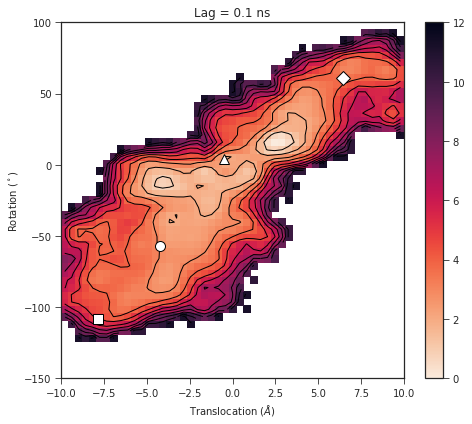

In [36]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(7, 6))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="rocket_r", vmax=12, label="kT")
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 0.1 ns")
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [37]:
from itertools import combinations

In [38]:
sb_ids = [42, 48, 47, 53]

In [41]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 100)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 100)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[0], xlim, ylim)
    )

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


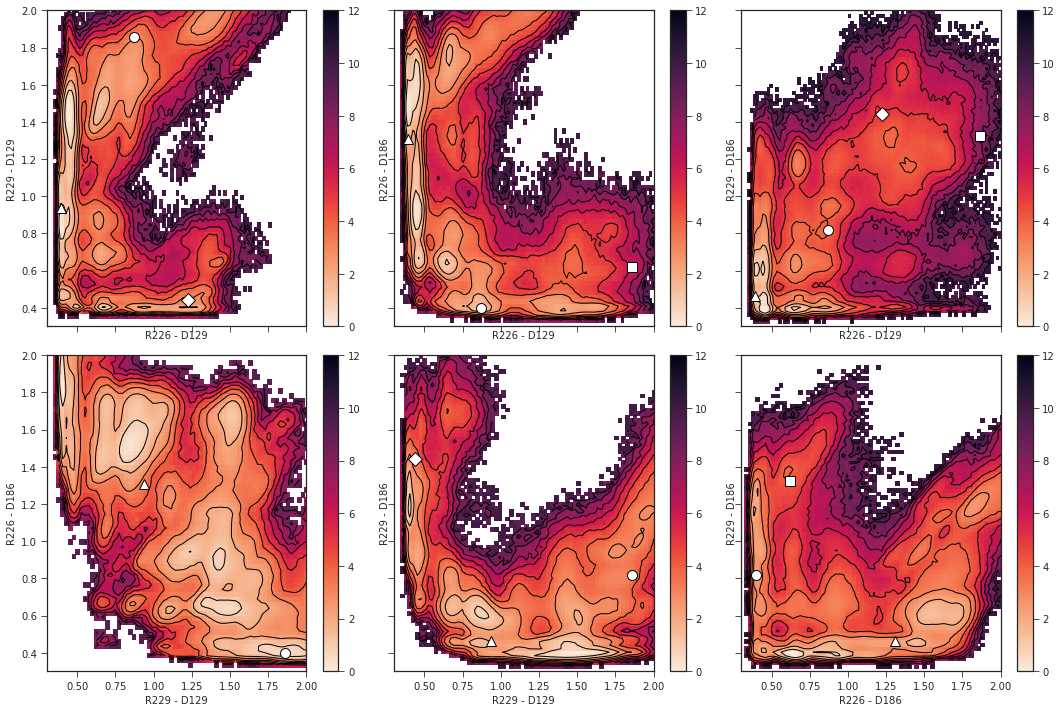

In [42]:
clines = np.linspace(0, 12, 13)
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for ((sb1, sb2), ax, pmf, xlim, ylim) in zip(
    combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
):
    # compute grid
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket_r", vmax=12, label="kT")
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
    ax.set_xlim([0.3, 2.0])
    ax.set_ylim([0.3, 2.0])
plotting.plot_sb_models(axes.flat, centroids=True)
f.tight_layout()

# Committors

In [43]:
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [44]:
len(in_domain)

381

In [45]:
q_downup = []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(
        extq.dga.forward_committor_sparse(basisF, com, in_domain, guessU, lag)
    )

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


In [46]:
np.save("../../data/feat5_ind1000_uu_suppl/q_downup.npy", q_downup)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## projections

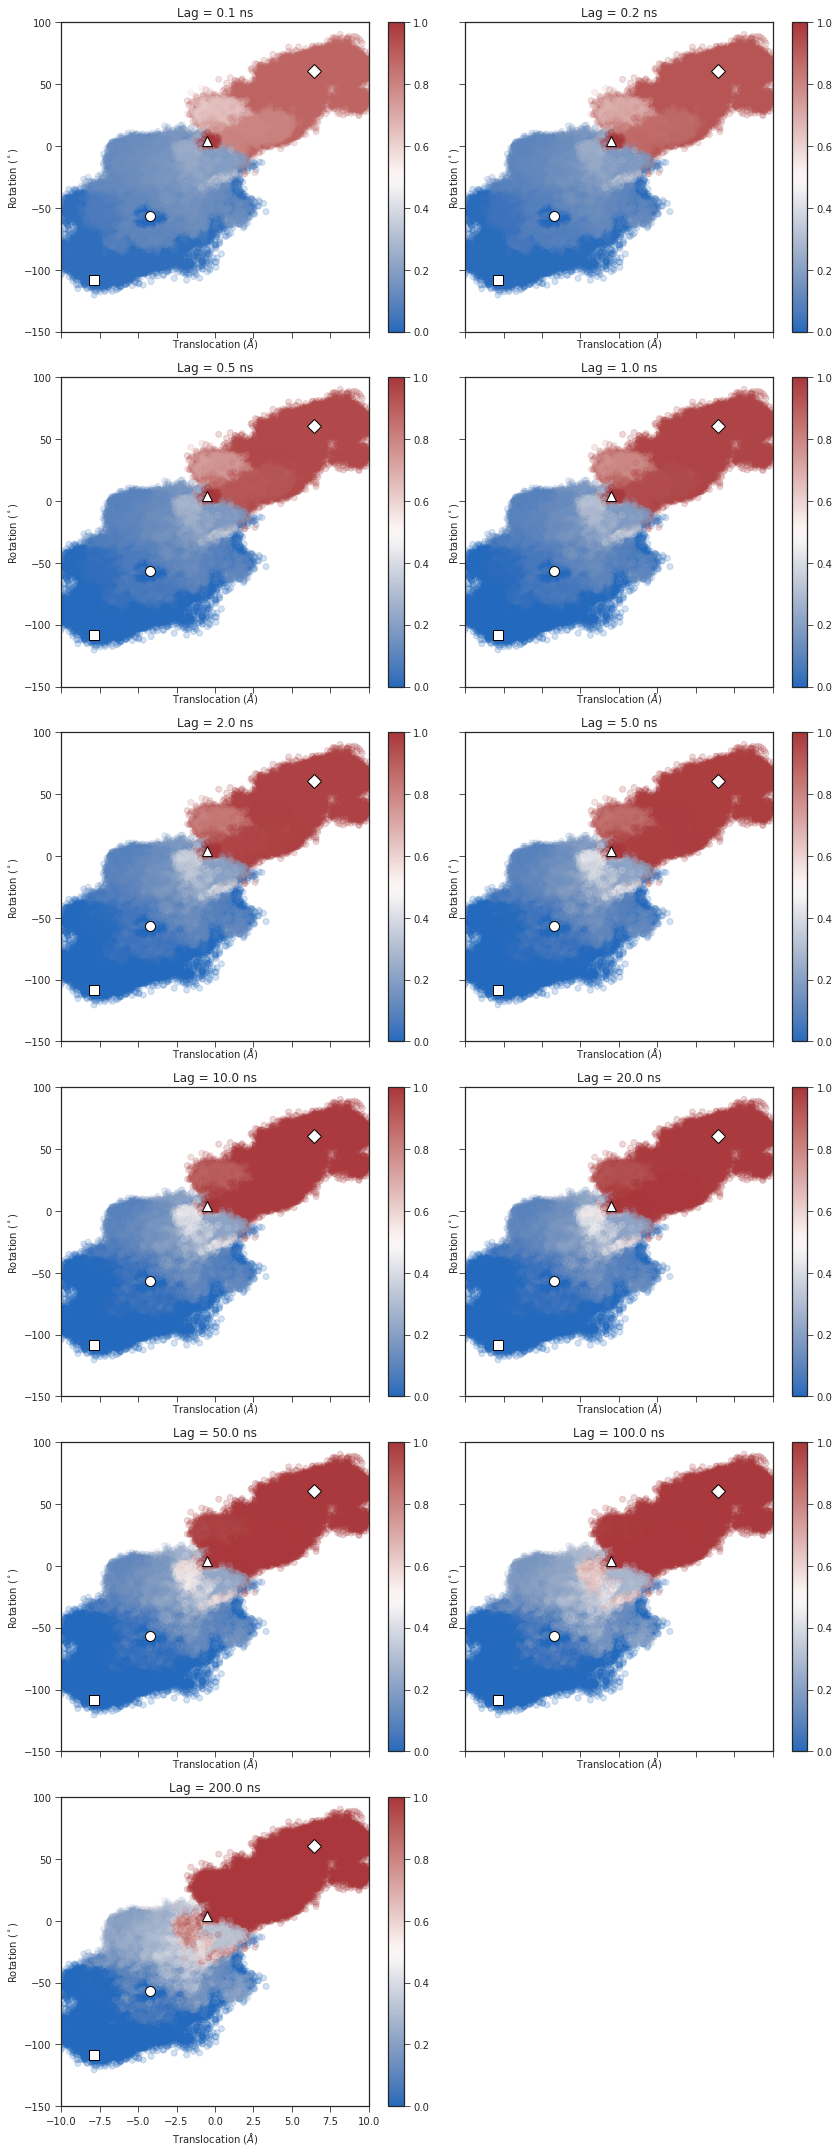

In [48]:
s = 10
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*cv_arr[::s].T, c=q_arr[::s], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True)
f.delaxes(axs[-1][-1])
f.tight_layout()

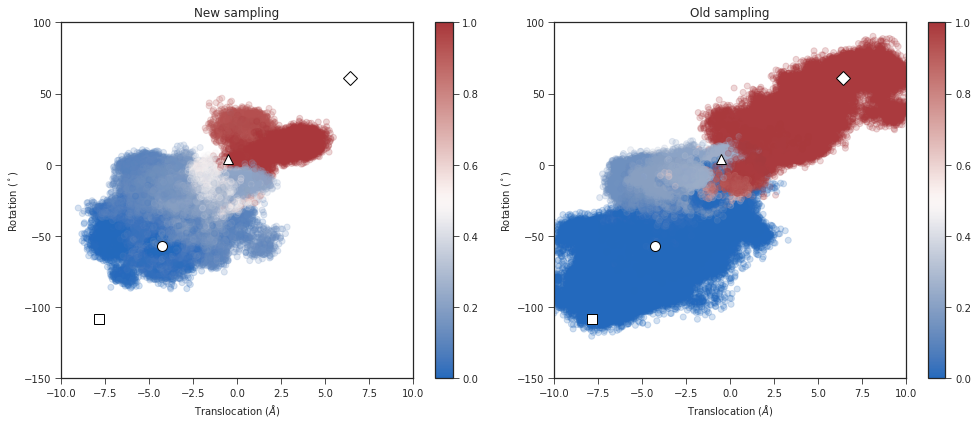

In [52]:
s = 10
f, (ax, ax2) = plt.subplots(1, 2, figsize=(14, 6))

st = 3_000_000
s = 5
q_arr = np.concatenate(q_downup[7]).clip(min=0.0, max=1.0)
h = ax.scatter(*cv_arr[st::s].T, c=q_arr[st::s], cmap="vlag", alpha=0.2)
cbar = plt.colorbar(h, ax=ax)
cbar.solids.set(alpha=1)
ax.set_title(f"New sampling")
plotting.format_cvs(ax, centroids=True)

s = 10
h2 = ax2.scatter(*cv_arr[:st:s].T, c=q_arr[:st:s], cmap="vlag", alpha=0.2)
cbar2 = plt.colorbar(h2, ax=ax2)
cbar2.solids.set(alpha=1)
ax2.set_title(f"Old sampling")
plotting.format_cvs(ax2, centroids=True)

f.tight_layout()

In [216]:
com = np.concatenate(weights[7])
q_arr = np.concatenate(q_downup[7])
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=com
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Committor, lag = 20 ns')

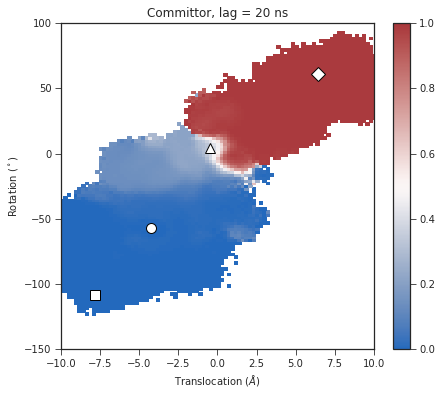

In [218]:
f, ax = plt.subplots(figsize=(7, 6))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag", vmin=0, vmax=1)
plt.colorbar(
    h,
    ax=ax,
)
plotting.format_cvs(ax, centroids=True)
plt.title("Committor, lag = 20 ns")

Text(0.5, 0.98, 'Committor, lag = 20.0 ns')

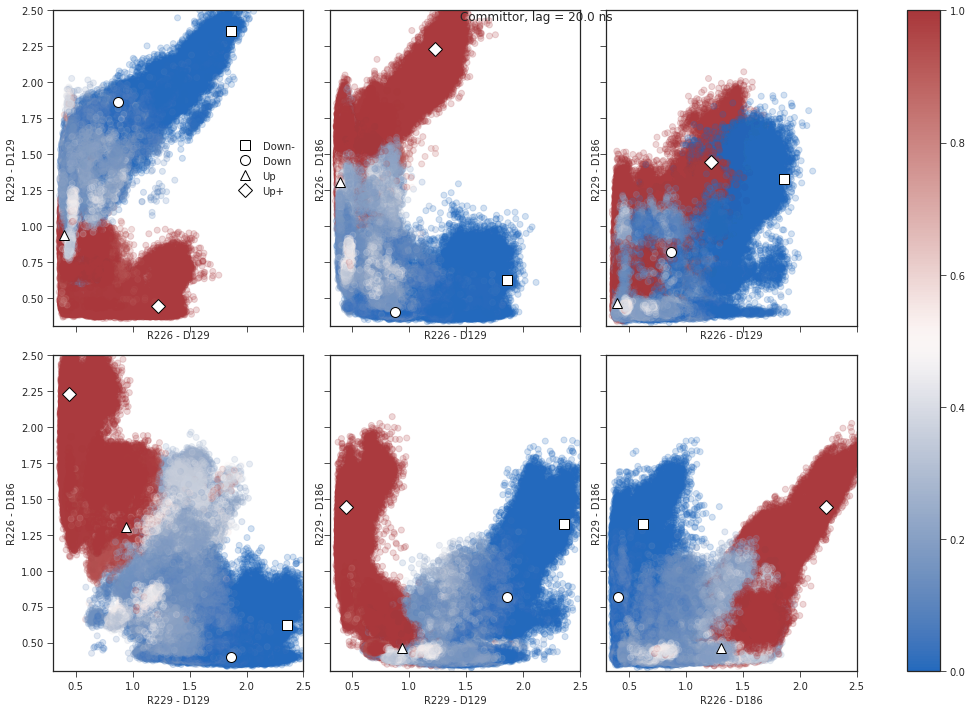

In [49]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

s = 10
q_arr = np.concatenate(q_downup[7])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        sb_arr[::s, sb1], sb_arr[::s, sb2], c=q_arr[::s], cmap="vlag", alpha=0.2
    )
    ax.set(
        xlabel=sb_labels[sb1 - 30],
        ylabel=sb_labels[sb2 - 30],
        xlim=[0.3, 2.5],
        ylim=[0.3, 2.5],
    )
f.tight_layout()
cbar = f.colorbar(h, ax=axes.ravel().tolist())
cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")

plt.suptitle(f"Committor, lag = {lags[7] * 0.1} ns")

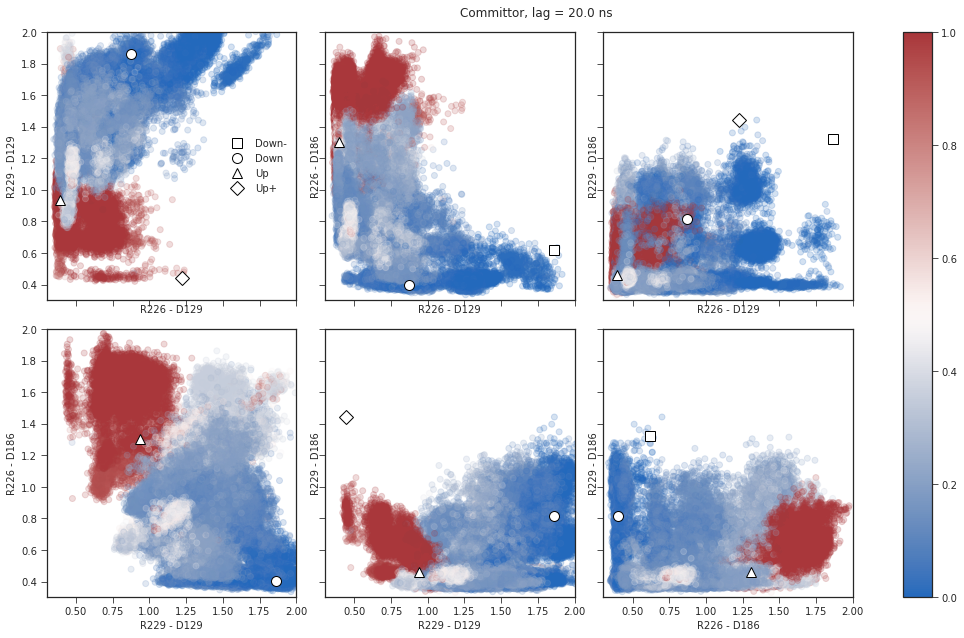

In [54]:
f, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, sharey=True)

s = 5
q_arr = np.concatenate(q_downup[7])
st = 3_000_000
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        sb_arr[st::s, sb1], sb_arr[st::s, sb2], c=q_arr[st::s], cmap="vlag", alpha=0.2
    )
    ax.set(
        xlabel=sb_labels[sb1 - 30],
        ylabel=sb_labels[sb2 - 30],
        xlim=[0.3, 2.0],
        ylim=[0.3, 2.0],
    )
plt.suptitle(f"Committor, lag = {lags[7] * 0.1} ns")
f.tight_layout()

cbar = f.colorbar(h, ax=axes.ravel().tolist())
cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")

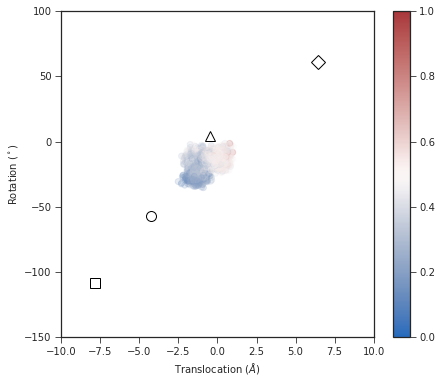

In [197]:
f, ax = plt.subplots(figsize=(7, 6))

i = 333
q = q_downup[7][i]
h = ax.scatter(*cv_trajs[i].T, c=q, cmap="vlag", alpha=0.2, vmin=0, vmax=1)
cbar = plt.colorbar(h, ax=ax)
cbar.solids.set(alpha=1)
plotting.format_cvs(ax, centroids=True)

In [200]:
suppl_xtcs = []
for i in range(83, 164):
    d = str(i).zfill(3)
    suppl_xtcs.append(f"../../suppl-runs/{d}/civsd_pro.xtc")
for j in range(2, 5):
    for i in range(83, 104):
        d = str(i).zfill(3)
        suppl_xtcs.append(f"../../suppl-runs/{d}/civsd_pro_{j}.xtc")
print(len(suppl_xtcs))

144


In [202]:
suppl_xtcs[333 - 237]

'../../suppl-runs/098/civsd_pro_2.xtc'

(0.3, 2.0)

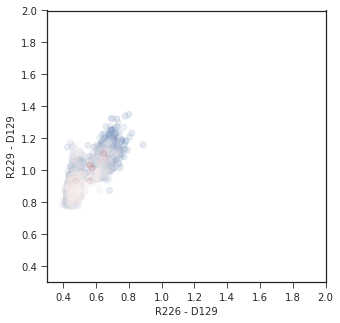

In [198]:
# i = 324
f = plt.subplots(figsize=(5, 5))
plt.scatter(
    sb_trajs[i][:, 42],
    sb_trajs[i][:, 48],
    c=q_downup[7][i],
    cmap="vlag",
    alpha=0.2,
    vmin=0,
    vmax=1,
)
plt.xlabel(sb_labels[12])
plt.ylabel(sb_labels[18])
plt.xlim([0.3, 2.0])
plt.ylim([0.3, 2.0])

(0.3, 2.0)

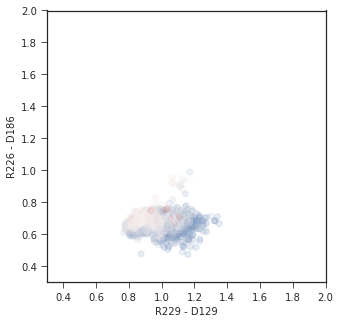

In [199]:
# i = 324
f = plt.subplots(figsize=(5, 5))
plt.scatter(
    sb_trajs[i][:, 48],
    sb_trajs[i][:, 47],
    c=q_downup[7][i],
    cmap="vlag",
    alpha=0.2,
    vmin=0,
    vmax=1,
)
plt.xlabel(sb_labels[18])
plt.ylabel(sb_labels[17])
plt.xlim([0.3, 2.0])
plt.ylim([0.3, 2.0])

## 3d projections

In [204]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

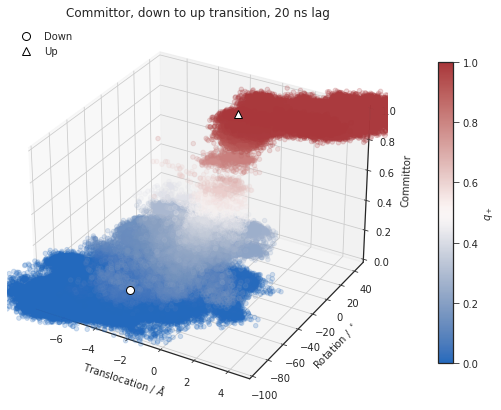

In [205]:
f = plt.figure(figsize=(9, 7))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[7])
ax.scatter(cv_arr[::s, 0], cv_arr[::s, 1], q[::s], c=q[::10], cmap="vlag", alpha=0.2)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("Committor")
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
ax.set_title("Committor, down to up transition, 20 ns lag")

ax.plot(centroids[1, 0], centroids[1, 1], 0, "o", mec="k", mfc="w", ms=8)
ax.plot(centroids[2, 0], centroids[2, 1], 1, "^", mec="k", mfc="w", ms=8)
ax.legend(["Down", "Up"], loc="upper left")

In [207]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

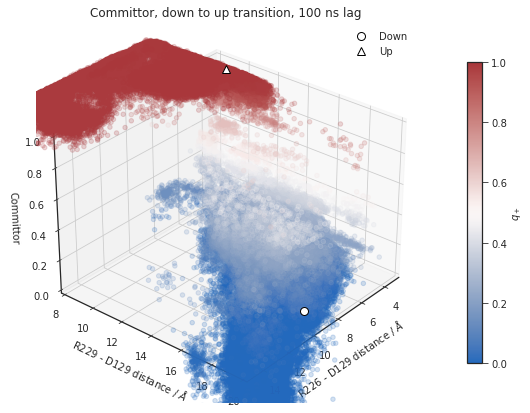

In [208]:
f = plt.figure(figsize=(9, 7))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[7]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[0]] * 10,
    sb_arr[::s, sb_ids[1]] * 10,
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([8, 20])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.1, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
ax.set_title("Committor, down to up transition, 100 ns lag")

ax.plot(
    feat2_models[1, sb_ids[0]] * 10,
    feat2_models[1, sb_ids[1]] * 10,
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]] * 10,
    feat2_models[2, sb_ids[1]] * 10,
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)
ax.legend(["Down", "Up"], loc="upper right")

ax.view_init(azim=40, elev=30)

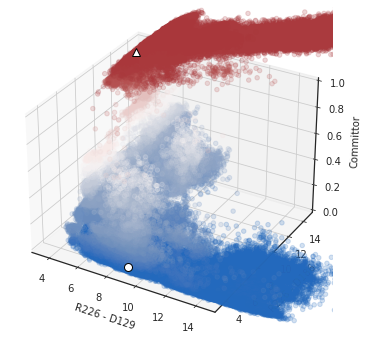

In [209]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[7]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[0]] * 10,
    sb_arr[::s, sb_ids[2]] * 10,
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]}")
ax.set_ylabel(f"{sb_labels[sb_ids[2] - 30]}")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([3, 15])
ax.set_zlim([0, 1])

ax.plot(
    feat2_models[1, sb_ids[0]] * 10,
    feat2_models[1, sb_ids[2]] * 10,
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]] * 10,
    feat2_models[2, sb_ids[2]] * 10,
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)

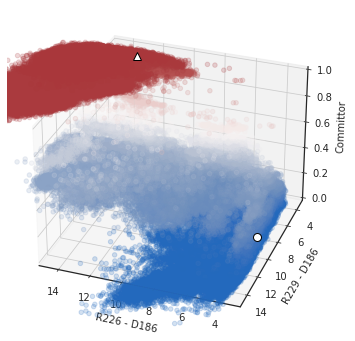

In [215]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[7]).clip(min=0, max=1)
ax.scatter(
    sb_arr[::s, sb_ids[2]] * 10,
    sb_arr[::s, sb_ids[3]] * 10,
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[2] - 30]}")
ax.set_ylabel(f"{sb_labels[sb_ids[3] - 30]}")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([3, 15])
ax.set_zlim([0, 1])

ax.plot(
    feat2_models[1, sb_ids[2]] * 10,
    feat2_models[1, sb_ids[3]] * 10,
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[2]] * 10,
    feat2_models[2, sb_ids[3]] * 10,
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)
ax.view_init(azim=110, elev=30)